Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Halloween Challenge

Challenge proposed during the 2023/2024 edition of the course. We are in the realm of *SET COVERING*, an NP-hard problem for which we are requested to find the **best solution** with the **fewest calls** to the fitness functions for:

* `num_points = [100, 1_000, 5_000]`
* `num_sets = num_points`
* `density = [.3, .7]` 

The problem has been settled so to have the **same pool of candidate sets** for each participant; in this way, it is possible to easily make a comparison between different solutions! We are glad to introduce an original algorithm which we designed in order to achieve several goals:

* Get a solution **close to the best** possible;
* Keep the number of calls to the fitness function **low**;
* Avoid a huge amount of computations and design a **very fast** algorithm;
* *Put ourselves in a **realistic scenario** where we don't necessarily have the amount of knowledge we were given in this case.

---

*By shifting many of the computations inside the fitness function, one would be able to greatly reduce the number of calls. This happens because we are simply moving all the computational burden inside the function, which instead should only evaluate the current and the candidate state. In order to keep our solution as fair and realistic as possible (and, so, to not exploit tricks to solve the problem in 3 steps, quite unrealistic isn't it?) we decided to use the most simple evaluation function, i.e. the one proposed by the Professor. Moreover, we also kept the most basic tweak function and we strongly avoided the need for extensive calculations during the search for the solution. We believe that, given the particular structure of the problem, finding a perfect solution would be easy; we don't like easy or pre-made things, so we designed from scratch a new algorithm to find the best trade-off between number of calls and goodness of the solution. Finally, even though stochastic, our algorithm, if tuned adequately, has a quite low variance; this is very important since, thanks to the high speed at which it runs, several iterations can be done until the best possible solution is found.

## Set Up

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from itertools import product
from random import random, randint, seed, sample
from scipy import sparse
from copy import copy
from functools import reduce
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist


# Function provided by the Professor to define the problem.
def make_set_covering_problem(num_points, num_sets, density):
    """Returns a sparse array where rows are sets and columns are the covered items"""
    seed(num_points * 2654435761 + num_sets + density)
    sets = sparse.lil_array((num_sets, num_points), dtype = bool)
    for s, p in product(range(num_sets), range(num_points)):
        if random() < density:
            sets[s, p] = True
    for p in range(num_points):
        sets[randint(0, num_sets - 1), p] = True
    return sets


# Set the number of elements/sets.
n = 100
PROBLEM_SIZE = NUM_SETS = n

# Define the sets.
x = make_set_covering_problem(n, n, .3)

# Just to ease the process.
SETS = x.toarray()
print("Element at row=42 and column=42:", x[1, 1])

Element at row=42 and column=42: False


## Methodology

To test the effectiveness of our solution, we have defined a baseline and a benchmark. The first is our lower bound, i.e. the performance we would get when considering a simple random tweaking; the idea is to not perform worse than this! The second is our upper bound, and it is what we would like to approach as much as possible with our solution; in order to have a very nice approximation of the optimum, we computed the solution using the steepest ascent algorithm.

In all the tests we use the following counters:

* `count_fitness`: the number of times `fitness` is called;
* `count_updates`: the number of updates of the current solution;
* `missing_steps`: the number of steps with no improvements before stopping the algorithm.

We always initialize `count_fitness = 1`, so to keep into account the first evaluation of the algorithm, and then we increase it by 1 for each comparison. However, in the following notebook you will usually find `fitness(new_state) > fitness(current_state)`, so should not we increase it by 2? Actually, since in this specific case the evaluation of `fitness` is not computationally expensive, we lazily avoid to store each time its result in a dedicated variable and simply recompute it each time. Even though wrong (at a code level) in a general case, it actually causes no problems in this specific situation (at a latency level), so we decided to keep it here and increment the counter just by 1 (at a conceptual level).

For what does it concerns `count_updates`, it represents the number of times we find a solution better than the actual one. It actually does not cover a paramount importance, but it is always nice to keep track of these additional statistics.

Finally, when `missing_steps` reaches a pre-defined treshold, the algorithm stops and returns the actual solution. This is done so to avoid running (and evaluating) for number of times always equal to the number of steps.

### Baseline

In [44]:
def tweak(state):
    new_state = copy(state)                 # The most simple tweaking: it  
    index = randint(0, PROBLEM_SIZE - 1)    # just changes the boolean value
    new_state[index] = not new_state[index] # associated to a random index.
    return new_state

def fitness(state):
    cost = sum(state)               # Prioritizes the number of elements        
    valid = np.sum(reduce(          # covered and subsequently the number
        np.logical_or,              # of sets needed to do so.
        [SETS[i] for i, t in enumerate(state) if t],                                          
        np.array([False for _ in range(PROBLEM_SIZE)]),
                          )
                   )
    return valid, -cost


In [61]:
current_state = [False for _ in range(PROBLEM_SIZE)]
print('(#elements_covered, #sets)\n')
print(fitness(current_state))

count_fitness = 1
count_updates = 0
missing_steps = 0

for step in range(100_000):
    
    new_state = tweak(current_state)
    count_fitness += 1
    
    if fitness(new_state) > fitness(current_state):
        current_state = new_state
        count_updates += 1
        print(fitness(current_state))
        missing_steps = 0  
    
    else:
        missing_steps += 1
    
    if missing_steps == 1000:   # Arbitrary.
        break
        
print('\nCount Fitness:', count_fitness)
print('Count Updates:', count_updates)

(#elements_covered, #sets)

(0, 0)
(28, -1)
(50, -2)
(66, -3)
(76, -4)
(85, -5)
(92, -6)
(94, -7)
(95, -8)
(97, -9)
(98, -10)
(99, -11)
(100, -12)
(100, -11)
(100, -10)
(100, -9)

Count Fitness: 1250
Count Updates: 15


### Steepest Ascent

In [63]:
def tweak(state, index):
    new_state = copy(state)                 # In this case we  
    index = randint(0, PROBLEM_SIZE - 1)    # keep track also
    new_state[index] = not new_state[index] # of the index.
    return new_state

def fitness(state):
    cost = sum(state)                       
    valid = np.sum(reduce(          
        np.logical_or,              
        [SETS[i] for i, t in enumerate(state) if t],                                          
        np.array([False for _ in range(PROBLEM_SIZE)]),
                          )
                   )
    return valid, -cost


In [64]:
current_state = [False for _ in range(PROBLEM_SIZE)]
candidate_state = current_state
print('(#updates, step, #calls_to_fitness, #elements_covered, #sets, fitness)\n')
print(fitness(current_state))

count_fitness = 0
best_index = 0
count_updates = 0

for step in range(1000):
    
    for i in range(PROBLEM_SIZE):
        new_state = tweak(current_state, i)
        
        count_fitness += 1
        if fitness(new_state) > fitness(candidate_state):
            candidate_state = new_state
            best_index = i
            count_updates += 1
            print(count_updates, step, count_fitness, fitness(candidate_state))

    current_state = candidate_state   

print('\nCount Fitness:', count_fitness)
print('Count Updates:', count_updates)

(#updates, step, #calls_to_fitness, #elements_covered, #sets, fitness)

(0, 0)
1 0 1 (26, -1)
2 0 2 (28, -1)
3 0 5 (31, -1)
4 0 7 (32, -1)
5 0 8 (34, -1)
6 0 12 (36, -1)
7 0 14 (39, -1)
8 0 53 (42, -1)
9 1 101 (55, -2)
10 1 102 (57, -2)
11 1 104 (62, -2)
12 1 108 (68, -2)
13 2 201 (77, -3)
14 2 202 (79, -3)
15 2 208 (81, -3)
16 2 243 (82, -3)
17 3 301 (91, -4)
18 3 304 (92, -4)
19 4 401 (95, -5)
20 4 402 (96, -5)
21 4 419 (97, -5)
22 4 485 (98, -5)
23 5 503 (100, -6)

Count Fitness: 100000
Count Updates: 23


### Our Method

Our algorithm can be partitioned in few steps:

* Precompute the pairwise distance/similarity between the elements in `SETS`. Since we have arrays of `bool`, we can see them in a mathematical fashion as vectors of 1's and 0's, representing points/vectors in the space. During our experiments, we have tuned three different metrics: the **euclidean distance**, the **cosine similarity** and the **manhattan distance**.ù
* Cluster the sets based on the precomputed measure. In our experiments we have considered a simple hierarchical clustering, but you can use you favourite clustering technique and test how does it perform! Given the nature of the algorithm we have chosen
* 

In [ ]:
similarity_matrix = cosine_similarity(SETS * 1)

In [ ]:
sns.set()  
plt.figure(figsize=(8, 6))

sns.heatmap(similarity_matrix, cmap = "YlGnBu", annot = False, 
            square=True, cbar = True, xticklabels = False, yticklabels = False)

plt.xlabel("Sets")
plt.ylabel("Sets")
plt.show()

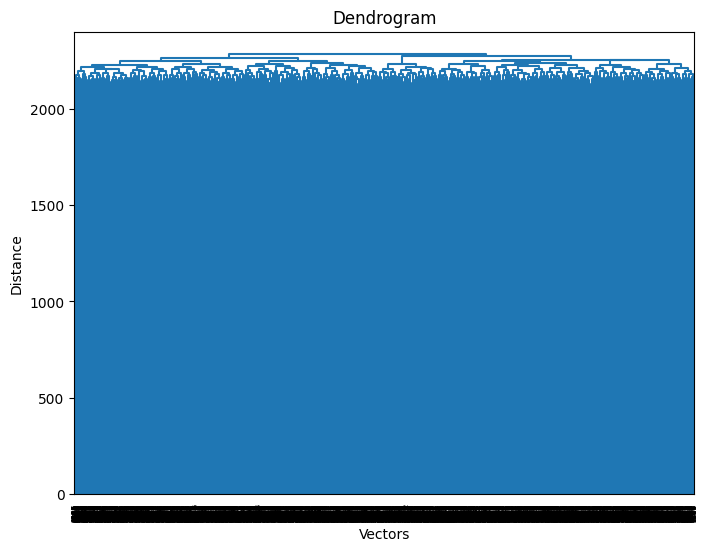

In [871]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Euclidean
# Cosine    not bad
# Manhattan Best

# Perform hierarchical clustering
linkage_matrix = linkage(SETS, method = 'complete', metric = 'cityblock')  # 1 - similarity for distance

# Plot the dendrogram (optional)
plt.figure(figsize=(8, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Vectors')
plt.ylabel('Distance')
plt.show()

threshold = 2255  # Set a threshold for similarity
clusters = fcluster(linkage_matrix, threshold, criterion = 'distance')

In [986]:
# TRADE-OFF between cost and number of calls (0.3 density)
# threshold = 6.5   # missing_steps = 50    # n = 100
# threshold = 21.4  # missing_steps = 50    # n = 1000
# threshold = 47    # missing_steps = 100   # n = 5000

# TRADE-OFF between cost and number of calls (0.7 density)
threshold = 2250   # missing_steps = 50    # n = 100

clusters = fcluster(linkage_matrix, threshold, criterion = 'distance')

(array([1377.,  461.,  610.,    0.,  485.,  444.,    0.,  819.,  401.,
         403.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

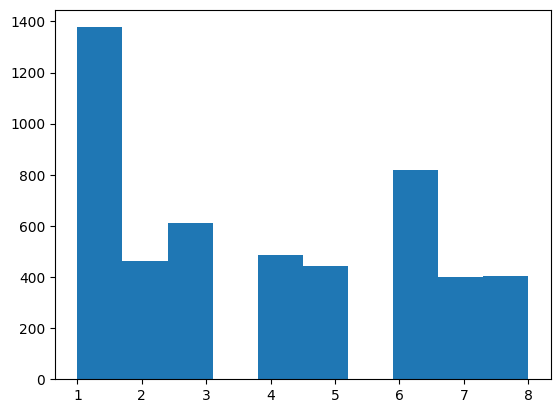

In [987]:
plt.hist(clusters, bins = 10)

In [988]:
from random import choice

dict_cluster_set = {clusters[i]:[] for i in range(PROBLEM_SIZE)}

for set in range(len(clusters)):
    dict_cluster_set[clusters[set]].append(set)

dict_cluster_weight = {}
for k, v in dict_cluster_set.items():
    val = sum(SETS[v]*1)/len(v)
    dict_cluster_weight[k] = val

# def tweak(state):
#     new_state = copy(state)
#     candidates = []
#     selected = []
#     for cluster in dict_cluster_set.keys():
#         chosen_one = choice(dict_cluster_set[cluster])
#         selected.append(chosen_one)
#         candidates.append(SETS[chosen_one])


#     return candidates, selected

# temp = [False for _ in range(PROBLEM_SIZE)]
# cand, chos = tweak(temp)

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

def tweak(state, index):
    new_state = copy(state)
    new_state[index] = not new_state[index]
    return new_state

def actual_solution(state): 
    vector = reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    return vector*1

In [1044]:
current_state = [False for _ in range(PROBLEM_SIZE)]
candidate_state = current_state
flag = False

print(fitness2(current_state))
count_fitness = 0
best_index = 0
missing_steps = 0

for step in range(10000):
    
    candidates = []
    selected = []

    # for each element in dict_cluster_weight, evaluate the manhattan distance with the actual solution

    clusters_to_select = []
    cs = actual_solution(current_state)
    for cluster in dict_cluster_weight.keys():
        # manhattan distance between two vectors 
        clusters_to_select.append((cluster,cdist([cs], [dict_cluster_weight[cluster]], metric = 'cityblock')[0][0]))

    # top n clusters 
    clusters_to_select = sorted(clusters_to_select, key = lambda x: x[1], reverse = True)[:int(len(clusters_to_select) * 2/4)]

    for name, value in clusters_to_select:
        chosen_one = choice(dict_cluster_set[name])  # Select a sample from the cluster.
        selected.append(chosen_one)                     # Append the selected sample.
        candidates.append(SETS[chosen_one])             # Append the select set.
    
    for i in range(len(candidates)):
        
        new_state = tweak(current_state, selected[i])
        
        count_fitness += 1
        if fitness2(new_state) > fitness2(candidate_state):
            candidate_state = new_state
            best_index = i
            print(step, count_fitness, fitness2(candidate_state))
            missing_steps = 0
        else:
            missing_steps += 1
    
        if missing_steps == 5:
            flag = True
            break
        
    if flag:
        break

    current_state = candidate_state   

print(fitness2(current_state))

print(count_fitness)

(0, 0)
0 1 (3507, -1)
0 3 (3530, -1)
0 4 (3567, -1)
1 5 (4537, -2)
1 6 (4568, -2)
1 7 (4572, -2)
2 9 (4871, -3)
2 10 (4884, -3)
2 11 (4886, -3)
3 13 (4958, -4)
3 14 (4959, -4)
3 15 (4971, -4)
4 17 (4991, -5)
4 18 (4992, -5)
5 21 (4997, -6)
5 23 (4999, -6)
5 24 (5000, -6)
(5000, -6)
29


(68, (5000, -6), 6, 40)

In [ ]:
# multiple experiments with different initial states
for i, elem in enumerate(initial_states):
    print(f'Initial state {i}')
    current_state = copy(elem)
    #print(current_state)
    #print(fitness2(current_state))
    count_fitness = 0
    for step in range(10_000):
        new_state = tweak(current_state)
        if fitness2(new_state) > fitness2(current_state):
            current_state = new_state
            count_fitness += 1
            #print(fitness2(current_state))
    print("final state fitness ", fitness2(current_state))
    print("count_fitness: ", count_fitness)
    print("End of iteration number ", i)
    print()

### Random N-1 Tweaking

In [ ]:
def tweak(state):
    new_state = copy(state)
    n_swapping = randint(0, PROBLEM_SIZE - 1)
    index_list = sample(range(0, PROBLEM_SIZE - 1), n_swapping)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]
print(current_state)
print(fitness2(current_state))
count_fitness = 0
count_updates = 0
missing_steps = 0

for step in range(10_000):
    new_state = tweak(current_state)
    count_fitness += 2
    if fitness2(new_state) > fitness2(current_state):
        current_state = new_state
        count_updates += 1
        print(fitness2(current_state))
        missing_steps = 0
    else:
        missing_steps += 1
    
    if missing_steps == 2000:
        break
        
print('Count Fitness:', count_fitness)
print('Count Updates:', count_updates)

### Random 2 Tweak

In [ ]:
def tweak(state):
    new_state = copy(state)
    index_list = sample(range(0, PROBLEM_SIZE - 1), 2)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]
print(fitness2(current_state))
count_fitness = 0
count_updates = 0
missing_steps = 0

for step in range(10_000):

    new_state = tweak(current_state)
    count_fitness += 2
    if fitness2(new_state) > fitness2(current_state):
        current_state = new_state
        print(fitness2(current_state))
        count_updates += 1
        missing_steps = 0
    else:
        missing_steps += 1

    if missing_steps == 1000:
        break
    
print(count_fitness)
print('Count Fitness:', count_fitness)
print('Count Updates:', count_updates)

### Random 3 tweak

In [ ]:
def tweak(state):
    new_state = copy(state)
    index_list = sample(range(0, PROBLEM_SIZE - 1), 3)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]

print(fitness2(current_state))
count_fitness = 0
count_updates = 0
missing_steps = 0

for step in range(10_000):
    new_state = tweak(current_state)
    count_fitness += 2
    if fitness2(new_state) > fitness2(current_state):
        current_state = new_state
        print(fitness2(current_state))
        count_updates += 1
        missing_steps = 0
    else:
        missing_steps += 1
    
    if missing_steps == 1000:
        break

print(count_fitness)
print('Count Fitness:', count_fitness)
print('Count Updates:', count_updates)

In [ ]:
def simulated_annealing(current_state, new_state, temperature):

    return np.exp(-(fitness2(current_state)[1] - fitness2(new_state)[1])/(temperature + 0.0001))

def tweak(state):
    new_state = copy(state)
    index_list = sample(range(0, PROBLEM_SIZE - 1), 2)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost


In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]

temperature = 0.01
print(fitness2(current_state))
count_fitness = 0
for step in range(10_000):

    new_state = tweak(current_state)
    temperature = temperature * 0.5 if step % 100 == 0 else temperature

    if fitness2(new_state) > fitness2(current_state):

        current_state = new_state
        print(fitness2(current_state))
        count_fitness += 1
    
    else:
        
        p = simulated_annealing(current_state, new_state, temperature)
        
        if random() < p:
        
            current_state = new_state
            print("SA:", fitness2(current_state))
            count_fitness += 1

print(count_fitness)

# Steepest Stochastic Ascent Hill Climbing (2 tweak)

In [ ]:
def tweak(state, index_list):
    new_state = copy(state)
    new_state = [not new_state[i] if i in index_list else new_state[i] for i in range(len(new_state))]
    return new_state

def fitness2(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost


In [ ]:
current_state = [False for _ in range(PROBLEM_SIZE)]
candidate_state = current_state
star_state = None
missing_steps = 0

print(fitness2(current_state))
count_fitness = 0
best_states = []
to_append = False

for step in range(1_000):
    candidate_state = current_state

    if missing_steps >= 5:
        if star_state is None or fitness2(star_state) > fitness2(star_state):
            star_state = copy(current_state)

        heavy_index_list = sample(range(0, PROBLEM_SIZE - 1), int(np.ceil(abs(fitness2(current_state)[1]/3))))
        print("Tried 5 times, no improvement...")
        current_state = [False for _ in range(PROBLEM_SIZE)]
        current_state = tweak(current_state, heavy_index_list) 
        candidate_state = current_state

        missing_steps = 0
        to_append = False

    for i in range(10_000):
        index_list = sample(range(0, PROBLEM_SIZE - 1), 2)
        new_state = tweak(current_state, index_list)
        if fitness2(new_state) > fitness2(candidate_state):
            missing_steps = 0
            candidate_state = new_state
            to_append = True
            print(step, fitness2(candidate_state))
        
    if current_state is not candidate_state:
        count_fitness += 1
        current_state = candidate_state
    else: 
        missing_steps += 1 

print("fitness_value:", fitness2(current_state)) if star_state is None else print("fitness_value:", fitness2(star_state))
print("count_fitness: ", count_fitness)